In [1]:
pip install traci

In [2]:
!apt-get update
!apt-get install sumo sumo-tools sumo-doc

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

 Retrying in 1 seconds
Episode 1/200 - Total Reward: 774
 Retrying in 1 seconds
Episode 2/200 - Total Reward: 604
 Retrying in 1 seconds
Episode 3/200 - Total Reward: 1066
 Retrying in 1 seconds
Episode 4/200 - Total Reward: 1326
 Retrying in 1 seconds
Episode 5/200 - Total Reward: 1235
 Retrying in 1 seconds
Episode 6/200 - Total Reward: 1156
 Retrying in 1 seconds
Episode 7/200 - Total Reward: 632
 Retrying in 1 seconds
Episode 8/200 - Total Reward: 1252
 Retrying in 1 seconds
Episode 9/200 - Total Reward: 1446
 Retrying in 1 seconds
Episode 10/200 - Total Reward: 1413
 Retrying in 1 seconds
Episode 11/200 - Total Reward: 1093
 Retrying in 1 seconds
Episode 12/200 - Total Reward: 1052
 Retrying in 1 seconds
Episode 13/200 - Total Reward: 1153
 Retrying in 1 seconds
Episode 14/200 - Total Reward: 1433
 Retrying in 1 seconds
Episode 15/200 - Total Reward: 1399
 Retrying in 1 seconds
Episode 16/200 - Total Reward: 1494
 Retrying in 1 seconds
Episode 17/200 - Total Reward: 1479
 Retrying

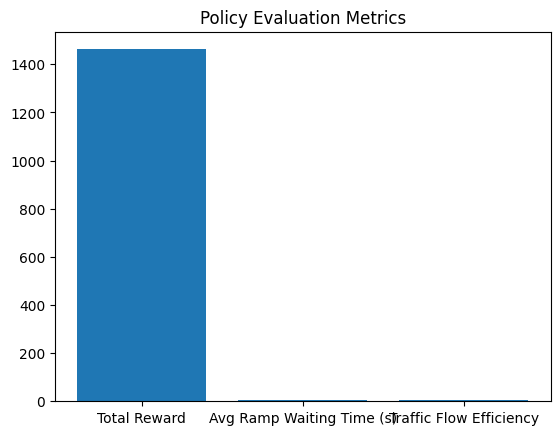

In [5]:
import os
import numpy as np
import traci
import matplotlib.pyplot as plt

# Q-Learning Parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration-exploitation balance
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.01
MAX_EPISODES = 200
MAX_STEPS = 1000
NUM_ACTIONS = 2  # Number of actions (e.g., 0: Increase ramp speed, 1: Decrease ramp speed)

# Environment Setup
SUMO_CMD = ["sumo", "-c", "/content/simulation.sumocfg"]

# State representation function
def get_state():
    highway_density = traci.edge.getLastStepVehicleNumber("highway")
    ramp_queue = traci.lane.getLastStepHaltingNumber("ramp_0")
    return (highway_density, ramp_queue)

# Discretize state space (example)
def discretize_state(highway_density, ramp_queue):
    highway_bucket = min(highway_density // 5, 19)  # Increase granularity
    ramp_bucket = min(ramp_queue // 1, 19)  # Increase granularity
    return highway_bucket * 20 + ramp_bucket

# Reward function
def compute_reward(highway_density, ramp_queue):
    throughput = traci.edge.getLastStepVehicleNumber("highway")
    waiting_penalty = ramp_queue * 2
    return throughput - waiting_penalty  # Reward throughput, penalize queue

# Step function to advance the simulation
def step_simulation(action):
    if action == 0:
        # Decrease speed by setting the max speed of the edge the ramp belongs to
        # Get the lane ID of the ramp (instead of the edge ID)
        lane_id = "ramp_0"
        current_speed = traci.lane.getMaxSpeed(lane_id)  # Get current speed of the lane
        traci.lane.setMaxSpeed(lane_id, max(1.0, current_speed - 1.0))
    elif action == 1:
        # Increase speed by setting the max speed of the edge the ramp belongs to
        # Get the lane ID of the ramp (instead of the edge ID)
        lane_id = "ramp_0"
        current_speed = traci.lane.getMaxSpeed(lane_id)  # Get current speed of the lane
        traci.lane.setMaxSpeed(lane_id, current_speed + 1.0)

    traci.simulationStep()
    highway_density = traci.edge.getLastStepVehicleNumber("highway")
    ramp_queue = traci.lane.getLastStepHaltingNumber("ramp_0")
    next_state = discretize_state(highway_density, ramp_queue)
    reward = compute_reward(highway_density, ramp_queue)
    done = traci.simulation.getMinExpectedNumber() == 0

    return next_state, reward, done

# Training loop
def train_q_learning():
    Q_table = np.zeros((400, NUM_ACTIONS))  # State-action space with 400 discrete states
    rewards_per_episode = []

    for episode in range(MAX_EPISODES):
        traci.start(SUMO_CMD)
        state = discretize_state(*get_state())
        total_reward = 0

        global EPSILON
        for step in range(MAX_STEPS):
            if np.random.uniform(0, 1) < EPSILON:
                action = np.random.randint(0, NUM_ACTIONS)  # Explore
            else:
                action = np.argmax(Q_table[state])  # Exploit

            next_state, reward, done = step_simulation(action)
            total_reward += reward

            # Q-Learning update rule
            Q_table[state, action] = Q_table[state, action] + ALPHA * (
                reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action]
            )

            state = next_state
            if done:
                break

        rewards_per_episode.append(total_reward)
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)  # Decay epsilon
        print(f"Episode {episode + 1}/{MAX_EPISODES} - Total Reward: {total_reward}")
        traci.close()

    np.save("/content/q_table_witout_traffic_lights.npy", Q_table)
    return rewards_per_episode  # Return rewards_per_episode

    # Visualization: Total Reward per Episode
    plt.figure()
    plt.plot(range(MAX_EPISODES), rewards_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")
    plt.show()

# Policy evaluation function
def evaluate_policy():
    Q_table = np.load("q_table_witout_traffic_lights.npy")
    traci.start(SUMO_CMD)
    state = discretize_state(*get_state())
    total_reward = 0
    total_ramp_waiting_time = 0
    total_vehicle_throughput = 0
    step = 0

    while step < MAX_STEPS:
        action = np.argmax(Q_table[state])
        next_state, reward, done = step_simulation(action)
        total_reward += reward

        # Collect metrics
        ramp_waiting_time = traci.lane.getWaitingTime("ramp_0")
        total_ramp_waiting_time += ramp_waiting_time
        highway_throughput = traci.edge.getLastStepVehicleNumber("highway")
        ramp_throughput = traci.lane.getLastStepVehicleNumber("ramp_0")
        total_vehicle_throughput += (highway_throughput + ramp_throughput)

        state = next_state
        step += 1

        if done:
            break

    traci.close()

    avg_ramp_waiting_time = total_ramp_waiting_time / step
    avg_vehicle_throughput = total_vehicle_throughput / step

    print(f"Evaluation Total Reward: {total_reward}")
    print(f"Average Ramp Waiting Time: {avg_ramp_waiting_time:.2f} seconds")
    print(f"Traffic Flow Efficiency (Vehicles/hour): {avg_vehicle_throughput:.2f}")

    # Visualization: Metrics
    metrics = [total_reward, avg_ramp_waiting_time, avg_vehicle_throughput]
    metric_names = ["Total Reward", "Avg Ramp Waiting Time (s)", "Traffic Flow Efficiency"]

    plt.figure()
    plt.bar(metric_names, metrics)
    plt.title("Policy Evaluation Metrics")
    plt.show()

if __name__ == "__main__":
    rewards_per_episode = train_q_learning()
    evaluate_policy()


In [6]:
# Visualization: Total Reward per Episode
def plot_smoothed_rewards(rewards, window=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.figure()
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards")
    plt.plot(range(len(rewards)), rewards, alpha=0.3, label="Original Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode (Smoothed)")
    plt.legend()
    plt.show()

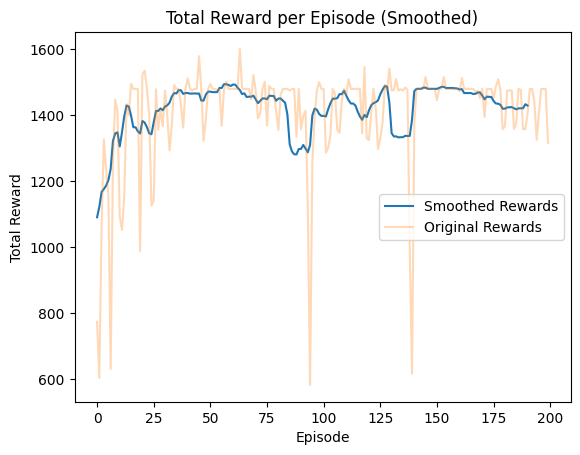

In [7]:
plot_smoothed_rewards(rewards_per_episode, window=10)